In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(font_scale=7)
# Based on "Stove Ownership" from XKCD by Randall Monroe
# http://xkcd.com/418/
plt.xkcd()


# 이항분포 시행횟수 N = 10
N = 10
# number of possible hypothesis H
# number of bins M = 1000  
M = 1000
# experiments (sample size=) 100,000 회
times = 100000
# fair coin
p = 0.5
# mu = p 베르누이 시행
mu = p

In [2]:
def flip_coins(N, M, p, times=1):
    """
    M (bins)개의 동전들을 N=10번 반복플립하는 이항분포 실험을 times회 실시한다. (times, M)
    3가지 동전의 결과값 array와 비율값 array를 return 한다.
    """
    outcomes = np.random.binomial(N, p, (times, M))
    
    # 이 중에서 첫번째 동전의 앞면 빈도수 c_1,
    # 무작위 선택한 동전의 앞면 빈도수 c_rand,
    # 앞면 빈도수가 최저값이 나온 동전의 앞면 빈도수 c_min
    
    # outcome values와 independent 한다.
    c_1 = outcomes[:,0]
    c_rand = np.apply_along_axis(np.random.choice, 1, outcomes)

    # outcome values에 dependent 한다.
    c_min = outcomes.min(axis=1)
 
    # 이들 각각의 비율값fractions
    v_1 = c_1/N
    v_rand = c_rand/N
    v_min = c_min/N
    
    return c_1, c_rand, c_min, v_1, v_rand, v_min

data = flip_coins(N, M, p, 100000)
new_data = [data[(i//2) + 3*(i%2)] for i in range(6)]

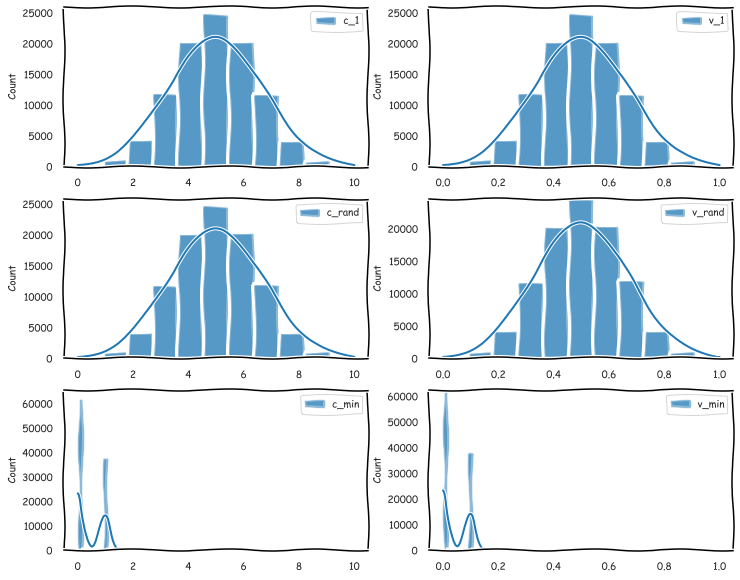

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(12, 10))
# fig.add_subplot()
labels = ["c_1", "v_1", "c_rand", "v_rand", "c_min", "v_min"]
for i, dt in enumerate(new_data):
    if i == 0:
        ax0 = fig.add_subplot(3,2,i+1)
    elif i == 1:
        ax1 = fig.add_subplot(3,2,i+1)
    elif i%2:
        ax = fig.add_subplot(3,2,i+1, ymargin=0 , sharex=ax1)
    else:
        ax = fig.add_subplot(3,2,i+1, sharex=ax0)
    sns.histplot(dt, 
             bins= 11, 
             element="bars", 
             kde=True, kde_kws={"bw_method": 'scott',"bw_adjust": 4},
             stat="count", 
             label=labels[i])
    plt.legend()    
plt.show();

In [4]:
errors = np.linspace(0, 0.5, times+1)[1:]
def hoeffding(error, N, M=1):
    return 2*M*np.exp(-2*error**2*N)

In [5]:
def theoretical_error_prob(mu, error, N):
    # Given a random variable nu, for fixed mu=0.5
    k = (mu - error)*N    
    err_prob = 2*binom.cdf(k=k, n=N, p=mu) 
    return err_prob

Does Hoeffding Inequality hold?  True


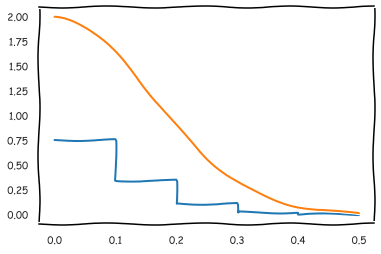

In [6]:
prb = theoretical_error_prob(mu, errors, N=10)
bd = hoeffding(errors, N)
plt.plot(errors, bd)
plt.plot(errors, prb)
print("Does Hoeffding Inequality hold? ", (prb < bd).all())
plt.show()

In [7]:
def experimental_error_prob(nu, mu, error, N=10):
    return (np.abs(nu - mu) > error).mean()

experimental_error_probs = []

for nu in data[3:]:
    experimental_error_probs.append(
        np.array([experimental_error_prob(nu, mu, error, N) for error in errors]))
experimental_error_probs

[array([0.75239, 0.75239, 0.75239, ..., 0.00184, 0.00184, 0.     ]),
 array([0.75342, 0.75342, 0.75342, ..., 0.0018 , 0.0018 , 0.     ]),
 array([1.     , 1.     , 1.     , ..., 0.62283, 0.62283, 0.     ])]

In case of v_1, does Hoeffding Inequality hold? True
In case of v_rand, does Hoeffding Inequality hold? True
In case of v_min, does Hoeffding Inequality hold? False


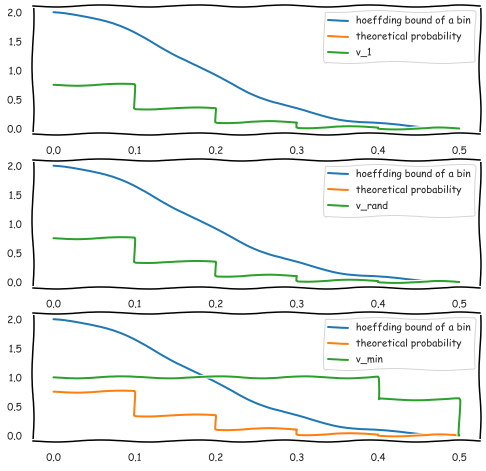

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))

labels = ["v_1", "v_rand", "v_min"]
for i, result in enumerate(experimental_error_probs):
    if i == 0:
        ax0 = fig.add_subplot(3,1,i+1)
        ax = ax0
    else:
        ax = fig.add_subplot(3,1,i+1, sharex=ax0)
        
    ax.plot(errors, bd, label="hoeffding bound of a bin")
    ax.plot(errors, prb, label="theoretical probability")
    ax.plot(errors, result, label=labels[i])
    plt.legend()
    print(f"In case of {labels[i]}, does Hoeffding Inequality hold?",
          (result <= bd).all())
plt.show();    